In [ ]:
import pandas as pd

df = pd.read_csv('/content/Gold Price.csv')

df=df.dropna()

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

#df['icon']= le.fit_transform(df['icon'])

y = df['High'].values
df=df.drop(columns = ['Date', 'High'])
X = df.values



In [ ]:
df

,temperature,humidity,dew_point,wind_bearing,wind_speed,wind_gust,pressure,uv_index,precip_intensity,icon
0,26.0,1.0,22.01,101.0,3.08,6.42,1008.45,0.0,0.0,4
1,25.0,1.0,22.06,105.0,2.94,6.28,1008.24,0.0,0.0,4
2,25.0,1.0,22.06,106.0,2.82,6.08,1007.90,0.0,0.0,4
3,24.0,1.0,21.87,106.0,2.63,5.74,1007.61,0.0,0.0,4
4,23.0,1.0,21.53,100.0,2.39,5.30,1007.51,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...
494,32.0,0.0,6.13,319.0,3.77,4.50,1011.58,5.0,0.0,0
495,32.0,0.0,5.74,321.0,4.08,5.20,1010.65,3.0,0.0,0
496,32.0,0.0,6.05,323.0,3.94,5.68,1010.31,1.0,0.0,0
497,31.0,0.0,6.85,326.0,3.61,6.08,1010.73,0.0,0.0,0


In [ ]:
from collections import Counter 
Counter(df['icon'])

Counter({0: 159, 1: 182, 2: 30, 3: 64, 4: 64})

In [ ]:

y=y.reshape(-1, 1)


import numpy as np
X=np.concatenate((X[1:], y[0:-1]), axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X= sc.fit_transform(X)

In [ ]:
from sklearn.model_selection import train_test_split
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, y[1:], test_size=0.2, shuffle=False, random_state=42)


In [ ]:
x_train1 = x_train1.reshape((x_train1.shape[0], x_train1.shape[1], 1))
x_test1 = x_test1.reshape((x_test1.shape[0], x_test1.shape[1], 1))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [ ]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    #outputs = layers.Dense(2, activation="softmax")(x)
    outputs = layers.Dense(1)(x)


    return keras.Model(inputs, outputs)

In [ ]:


input_shape = x_train1.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

'''
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-2),
    metrics=["sparse_categorical_accuracy"],
)
'''
model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["mean_absolute_error"],
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 1)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 6, 1)        2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 6, 1)        7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [ ]:
'''
model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_absolute_error"],
)
model.summary()
'''

callbacks = [keras.callbacks.EarlyStopping(patience=1000, restore_best_weights=True)]

history=model.fit(
    x_train1,
    y_train1,
    validation_data=(x_test1, y_test1),
    epochs=2000,
    batch_size=64,
    callbacks=callbacks,
)


Epoch 1/2000
26/26 [==============================] - 5s 34ms/step - loss: 29242.7891 - mean_absolute_error: 29242.7891 - val_loss: 39315.4062 - val_mean_absolute_error: 39315.4062
Epoch 2/2000
26/26 [==============================] - 0s 14ms/step - loss: 9051.8643 - mean_absolute_error: 9051.8643 - val_loss: 19575.6875 - val_mean_absolute_error: 19575.6875
Epoch 3/2000
26/26 [==============================] - 0s 14ms/step - loss: 5432.1255 - mean_absolute_error: 5432.1255 - val_loss: 18965.9141 - val_mean_absolute_error: 18965.9141
Epoch 4/2000
26/26 [==============================] - 0s 14ms/step - loss: 5043.6436 - mean_absolute_error: 5043.6436 - val_loss: 17949.7715 - val_mean_absolute_error: 17949.7715
Epoch 5/2000
26/26 [==============================] - 0s 14ms/step - loss: 5030.5034 - mean_absolute_error: 5030.5034 - val_loss: 19891.2852 - val_mean_absolute_error: 19891.2852
Epoch 6/2000
26/26 [==============================] - 0s 15ms/step - loss: 4878.4146 - mean_absolute_er

In [ ]:
#testing prediction
ypred=model.predict(x_test1)
#testing prediction

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error, mean_squared_log_error, mean_poisson_deviance, mean_gamma_deviance
print('mse: ', mean_squared_error(ypred, y_test1))
print('mae: ', mean_absolute_error(ypred, y_test1))
print('r2_score: ', r2_score(ypred, y_test1))
print('explained_variance_score: ', explained_variance_score(ypred, y_test1))
print('max_error: ', max_error(ypred, y_test1))
#print('mean_squared_log_error: ', mean_squared_log_error(ypred, y_test1))
print('mean_poisson_deviance: ', r2_score(ypred, y_test1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(ypred, y_test1))

mse:  168608.26185788075
mae:  353.30832078313256
r2_score:  0.9597361798336659
explained_variance_score:  0.9893824909045499
max_error:  1681.41015625
mean_poisson_deviance:  0.9597361798336659


In [ ]:
#training prediction
xpred=model.predict(x_train1)
print('mse: ', mean_squared_error(xpred, y_train1))
print('mae: ', mean_absolute_error(xpred, y_train1))
print('r2_score: ', r2_score(xpred, y_train1))
print('explained_variance_score: ', explained_variance_score(xpred, y_train1))
print('max_error: ', max_error(xpred, y_train1))
#print('mean_squared_log_error: ', mean_squared_log_error(xpred, y_train1))
print('mean_poisson_deviance: ', r2_score(xpred, y_train1))
#print('mean_gamma_deviance: ',  mean_gamma_deviance(xpred, y_train1))

mse:  39459.795811911135
mae:  112.25198379000604
r2_score:  0.997862941068476
explained_variance_score:  0.9982266450913867
max_error:  1879.59375
mean_poisson_deviance:  0.997862941068476


In [ ]:
xx=[]
for i in range(len(ypred)):
    xx.append(i)

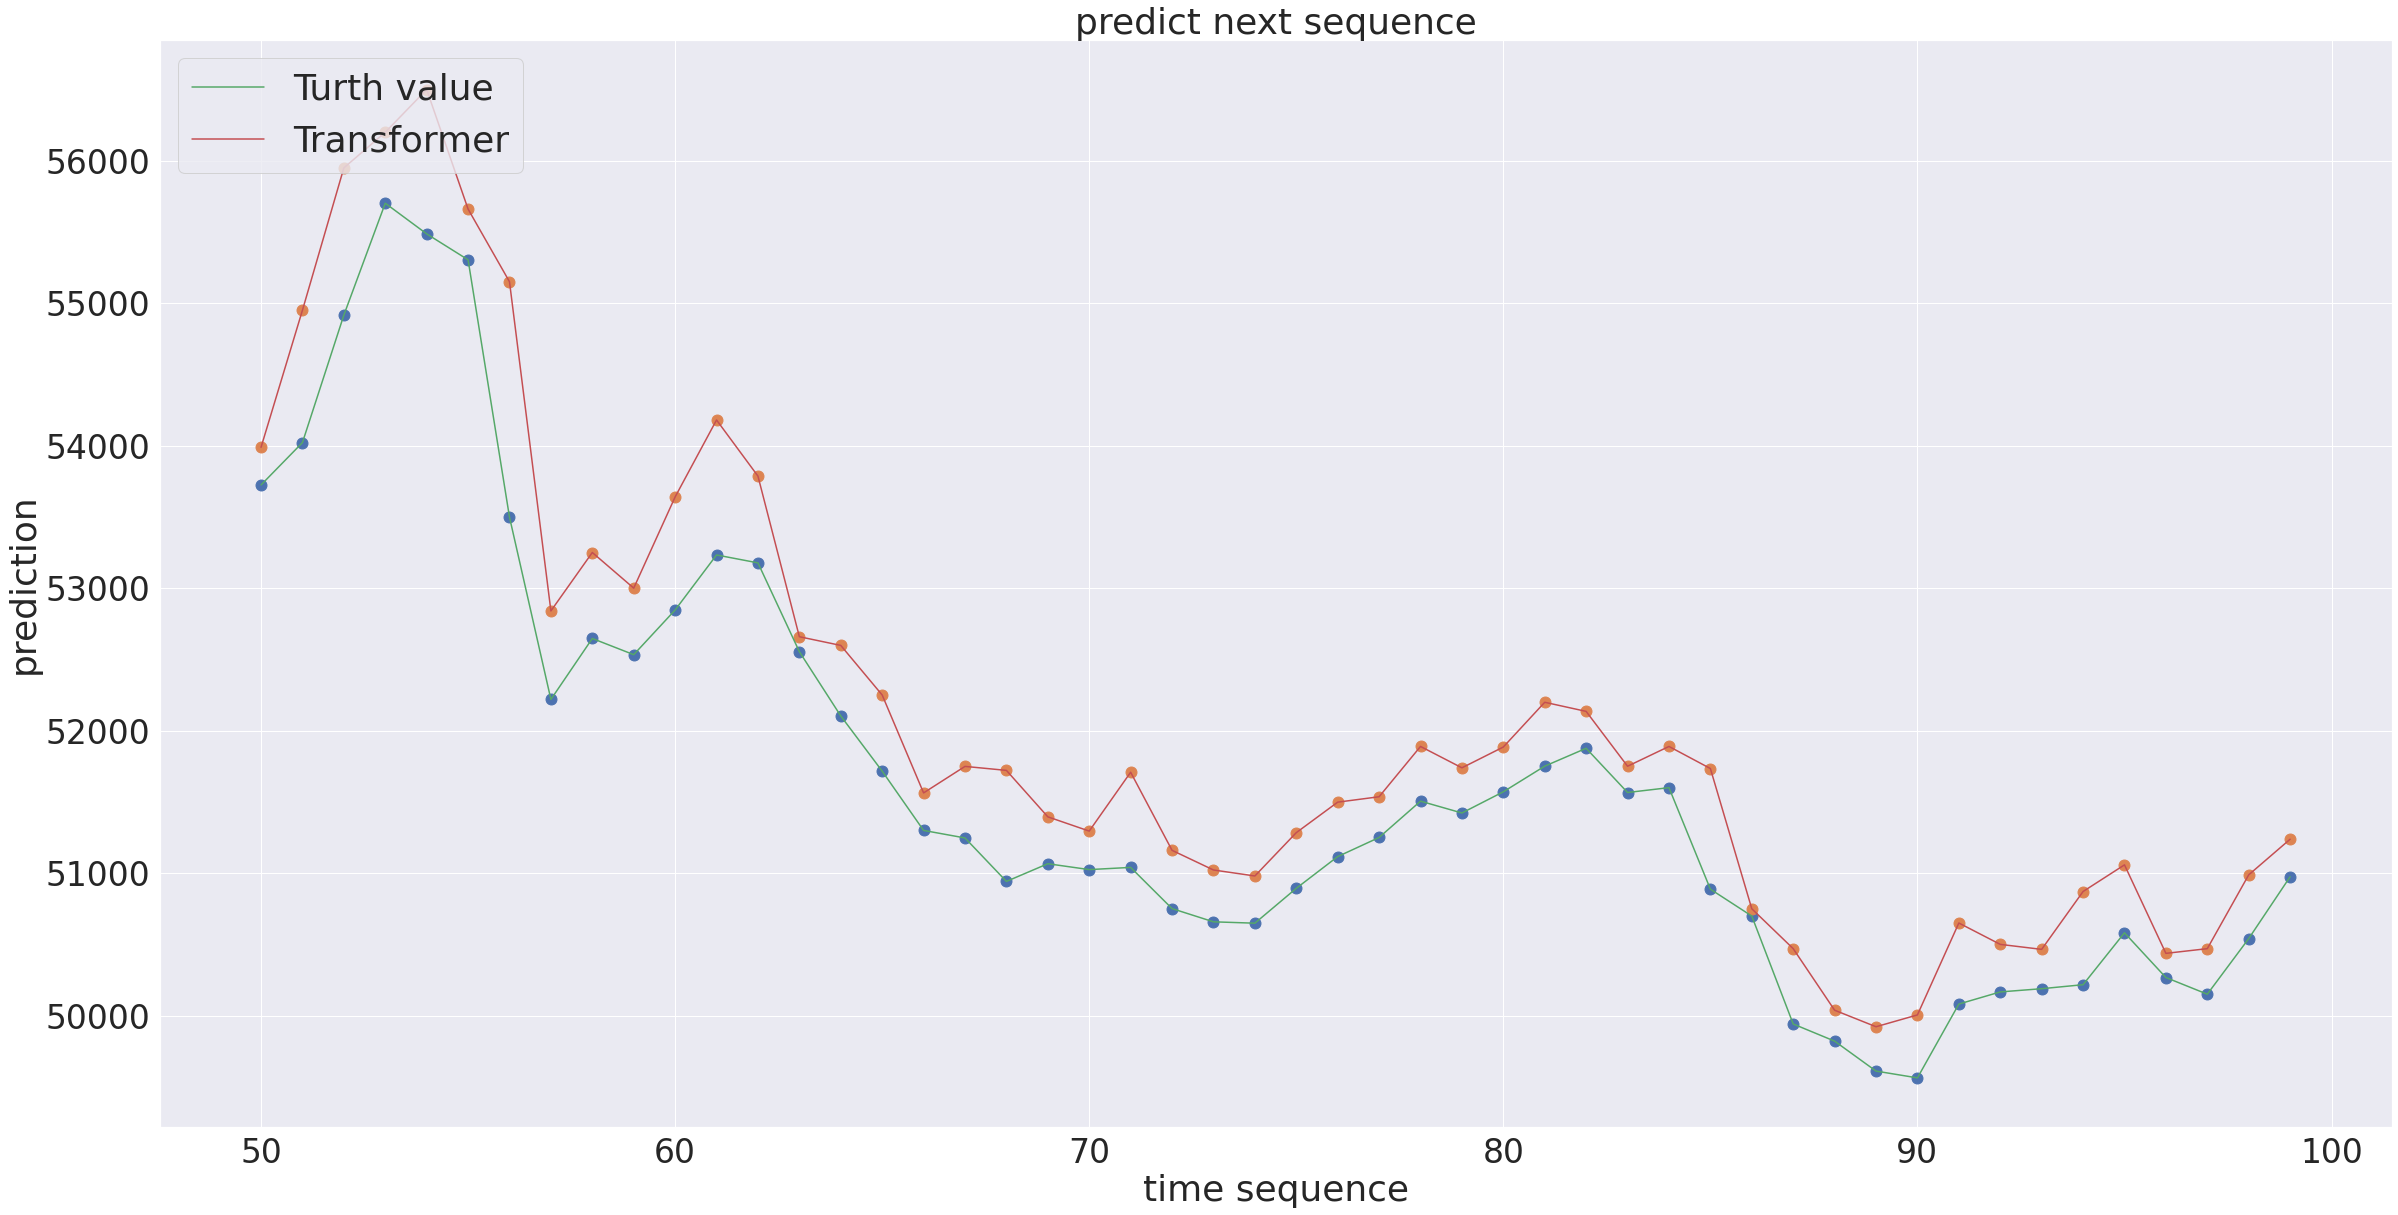

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
i=50
j=100
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale = 3)
plt.figure()
plt.plot(xx[i:j],ypred[i:j], color='g', label='Turth value', zorder=10)
plt.plot(xx[i:j],y_test1[i:j], color='r', label='Transformer')

plt.scatter(xx[i:j],ypred[i:j],  s=120, zorder=2)
plt.scatter(xx[i:j],y_test1[i:j],  s=120, zorder=2)

plt.legend(loc="upper left", fontsize=36)
plt.title('predict next sequence', fontsize=36)
plt.xlabel('time sequence', fontsize=36)
plt.ylabel('prediction', fontsize=36)
plt.show()

In [ ]:
import pickle
with open('trans_y_predict.pickle', 'wb') as handle:
    pickle.dump(ypred, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import pickle
with open('trans_x_predict.pickle', 'wb') as handle:
    pickle.dump(xpred, handle, protocol=pickle.HIGHEST_PROTOCOL)